In [1]:
import torch
from custom_models import load_custom_class
import seaborn as sns
import matplotlib.pyplot as plt

# sub class from modelling_bert "RobertaForSequenceClassification" and override the forward method
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [2]:
from tokenization_methods.character_split import custom_tokenization
from custom_tokenizer_abstract import CustomTokenizerGeneral

# repo_link_nli = "cross-encoder/nli-distilroberta-base"
repo_link_nli = "cross-encoder/nli-MiniLM2-L6-H768"

model_args = {}

tokenizer_nli, model_nli = load_custom_class(repo_link_nli, device, **model_args)
vocabulary_id2tok = {tok_id:tok for tok, tok_id in tokenizer_nli.vocab.items()}

# BERT
# custom_tokenizer = CustomTokenizerGeneral(tokenizer_nli, custom_tokenization, separator_marker="##", special_space_token="")
# RoBERTa
custom_tokenizer = CustomTokenizerGeneral(tokenizer_nli, custom_tokenization, separator="", special_space_token="Ġ")

Tensors and operations will be done on cuda:0.


In [3]:
import json
import pandas as pd

# data_path = "data/" + "/snli_1.0" + "/snli_1.0_test.jsonl"
data_path = "data/" + "/multinli_1.0" + "/multinli_1.0_dev_mismatched.jsonl"

data = []
limit = 500_000
with open(data_path, "r") as file:
    for _ in range(limit):
        json_obj = file.readline()
        if json_obj != "":
            data += [json.loads(json_obj)]
        else:
            break


In [4]:
data_df = {
    "label": [],
    "sent1": [],
    "sent2": []
}

for datum in data:
    data_df["label"] += [datum["gold_label"]]
    data_df["sent1"] += [datum["sentence1"]] # premise
    data_df["sent2"] += [datum["sentence2"]] # hypothesis

data_df = pd.DataFrame(data_df)
print(data_df.shape)
data_df.head()

(10000, 3)


,label,sent1,sent2
0,contradiction,Your contribution helped make it possible for ...,Your contributions were of no help with our st...
1,contradiction,"The answer has nothing to do with their cause,...",Dictionaries are indeed exercises in bi-unique...
2,entailment,We serve a classic Tuscan meal that includes ...,We serve a meal of Florentine terrine.
3,contradiction,"A few months ago, Carl Newton and I wrote a le...",Carl Newton and I have never had any other pre...
4,entailment,"I was on this earth you know, I've lived on th...",I don't yet know the reason why I have lived o...


In [5]:
idx_example = 9990
example = data_df.iloc[idx_example]["sent1"] + " " + data_df.iloc[idx_example]["sent2"]
example_custom = (data_df.iloc[idx_example]["sent1"], data_df.iloc[idx_example]["sent2"])

In [ ]:
import shap
# from prediction_utilities import get_prediction_model_outputs
from functools import partial

tokenizer_args_normal = {
    "return_tensors": "pt",
    "padding": "longest"
}

import numpy as np
# print(get_prediction(premise_hypothesis=[example], device=device, model_nli=model_nli, custom_tokenizer=tokenizer_nli, **tokenizer_args_normal))

def get_prediction_model_outputs(premise_hypothesis, model_nli: callable, tokenizer: callable, is_custom=False, **tokenization_args) -> dict:
    if is_custom:
        text_input = premise_hypothesis
    else:
        text_input = premise_hypothesis
    tok_output = tokenizer(text_input, **tokenization_args)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    tok_output.to(device)
    model_outputs = model_nli(**tok_output)
    probs = torch.softmax(model_outputs.logits, dim=1)
    return probs

explainer = shap.Explainer(partial(get_prediction_model_outputs, model_nli=model_nli, tokenizer=tokenizer_nli, is_custom=False, **tokenizer_args_normal), tokenizer_nli, output_names=list(model_nli.config.label2id.keys()))
result = explainer([example])
from IPython.display import display, HTML

shap_plot = shap.plots.text(result, display=False)
print(f"Actual label: {data_df.iloc[idx_example]['label']}")
display(HTML(shap_plot))

Actual label: contradiction


In [1]:
import shap
from functools import partial

import shap.maskers

tokenizer_args_custom = {
    "do_lowercase": False,
    "return_tensors": "pt",
    "padding": "longest",
    "return_offsets_mapping": True
}

def get_prediction_model_outputs(premise_hypothesis, model_nli: callable, tokenizer: callable, is_custom=False, **tokenization_args) -> dict:
    if is_custom:
        text_input = premise_hypothesis
    else:
        text_input = premise_hypothesis
    print(text_input)
    tok_output = tokenizer(text_input, **tokenization_args)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    tok_output.to(device)
    model_outputs = model_nli(**tok_output)
    probs = torch.softmax(model_outputs.logits, dim=1)
    return probs

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


import numpy as np
# print(get_prediction(premise_hypothesis=example_custom, device=device, model_nli=model_nli, custom_tokenizer=custom_tokenizer, **tokenizer_args_normal))
from custom_models import load_custom_class

repo_link_nli = "cross-encoder/nli-MiniLM2-L6-H768"
tokenizer_nli, model_nli = load_custom_class(repo_link_nli, device, **{})


from tokenization_methods.character_split import custom_tokenization
from custom_tokenizer_abstract_single import CustomTokenizerGeneral
custom_tokenizer = CustomTokenizerGeneral(tokenizer_nli, custom_tokenization, separator="", special_space_token="Ġ")

masker = shap.maskers.Text(custom_tokenizer, mask_token=tokenizer_nli.mask_token)
explainer = shap.Explainer(partial(get_prediction_model_outputs, model=model_nli, tokenizer=custom_tokenizer, is_custom=True, **tokenizer_args_custom), masker, output_names=list(model_nli.config.label2id.keys()))
result = explainer([example])

Tensors and operations will be done on cuda:0.
 ??


IndexError: string index out of range

In [10]:
from IPython.display import display, HTML

# GLOBAL SHAPLEY COMPUTATIONS - WHICH TOKENS CONTRIBUTE MOST TO CERTAIN LABELS
shap_plot = shap.plots.text(result, display=False)
print(f"Actual label: {data_df.iloc[idx_example]['label']}")
display(HTML(shap_plot))

Actual label: contradiction


In [38]:
import json

def load_data(file_name):
    data = {
            "id": [],
            "label": [],
            "prob": [],
            "all_prob": []
    }
    with open(file_name, "r") as file:
        for line in file:
            aux_dict = json.loads(line)

            data["id"] += [aux_dict["id"]]
            data["label"] += [aux_dict["result"]["label"]]
            data["prob"] += [aux_dict["result"]["prob"]]
            data["all_prob"] += [aux_dict["result"]["all_prob"]]

    return data

results_adj = load_data("results/minilm/multinli_1.0_dev_mismatched-adj-minilm.jsonl")
results_noun = load_data("results/minilm/multinli_1.0_dev_mismatched-noun-minilm.jsonl")
results_standard = load_data("results/minilm/multinli_1.0_dev_mismatched-standard-minilm.jsonl")
results_char = load_data("results/minilm/multinli_1.0_dev_mismatched-char-minilm.jsonl")
results_verb = load_data("results/minilm/multinli_1.0_dev_mismatched-verb-minilm.jsonl")


In [39]:
gt_labels=data_df["label"].to_numpy()
gt_labels_num = data_df["label"].value_counts().to_dict()

gt_labels_num = dict(sorted(gt_labels_num.items(), key=lambda x:x[0]))

gt_labels_num

{'-': 168, 'contradiction': 3240, 'entailment': 3463, 'neutral': 3129}

In [40]:
from collections import defaultdict
import numpy as np

def get_labels_number(res_dict):
    labels_model_custom = defaultdict(int)
    for label in res_dict["label"]:
        labels_model_custom[label] += 1
    labels_model_custom = dict(sorted(labels_model_custom.items(), key=lambda x:x[0]))
    print(labels_model_custom)
    return labels_model_custom

results_adj_num = get_labels_number(results_adj)
results_noun_num = get_labels_number(results_noun)
results_standard_num = get_labels_number(results_standard)
results_char_num = get_labels_number(results_char)
results_verb_num = get_labels_number(results_verb)

results_standard_labels = np.asarray(results_standard["label"])
results_adj_labels = np.asarray(results_adj["label"])
results_noun_labels = np.asarray(results_noun["label"])
results_char_labels = np.asarray(results_char["label"])
results_verb_labels = np.asarray(results_verb["label"])


{'contradiction': 2871, 'entailment': 5079, 'neutral': 2050}
{'contradiction': 2756, 'entailment': 5079, 'neutral': 2165}
{'contradiction': 3008, 'entailment': 3709, 'neutral': 3283}
{'contradiction': 567, 'entailment': 9349, 'neutral': 84}
{'contradiction': 2904, 'entailment': 5041, 'neutral': 2055}


In [35]:
results_char.keys()

dict_keys(['id', 'label', 'prob'])

Text(0, 0.5, 'Char tok')

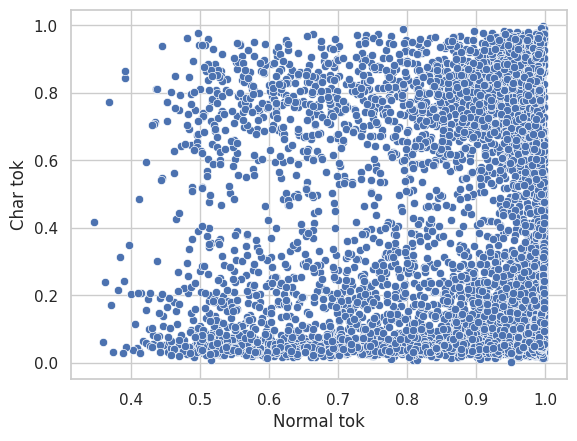

In [48]:
label = "entailment"
standard_cont = [prob for label, prob in zip(results_standard["label"], results_standard["prob"]) if label == label]
char_cont = [prob[label] for label, prob in zip(results_standard["label"], results_char["all_prob"]) if label == label]

sns.scatterplot(x=standard_cont, y=char_cont)
plt.xlabel("Normal tok")
plt.ylabel("Char tok")

In [ ]:
sns.scatterplot(x=res)

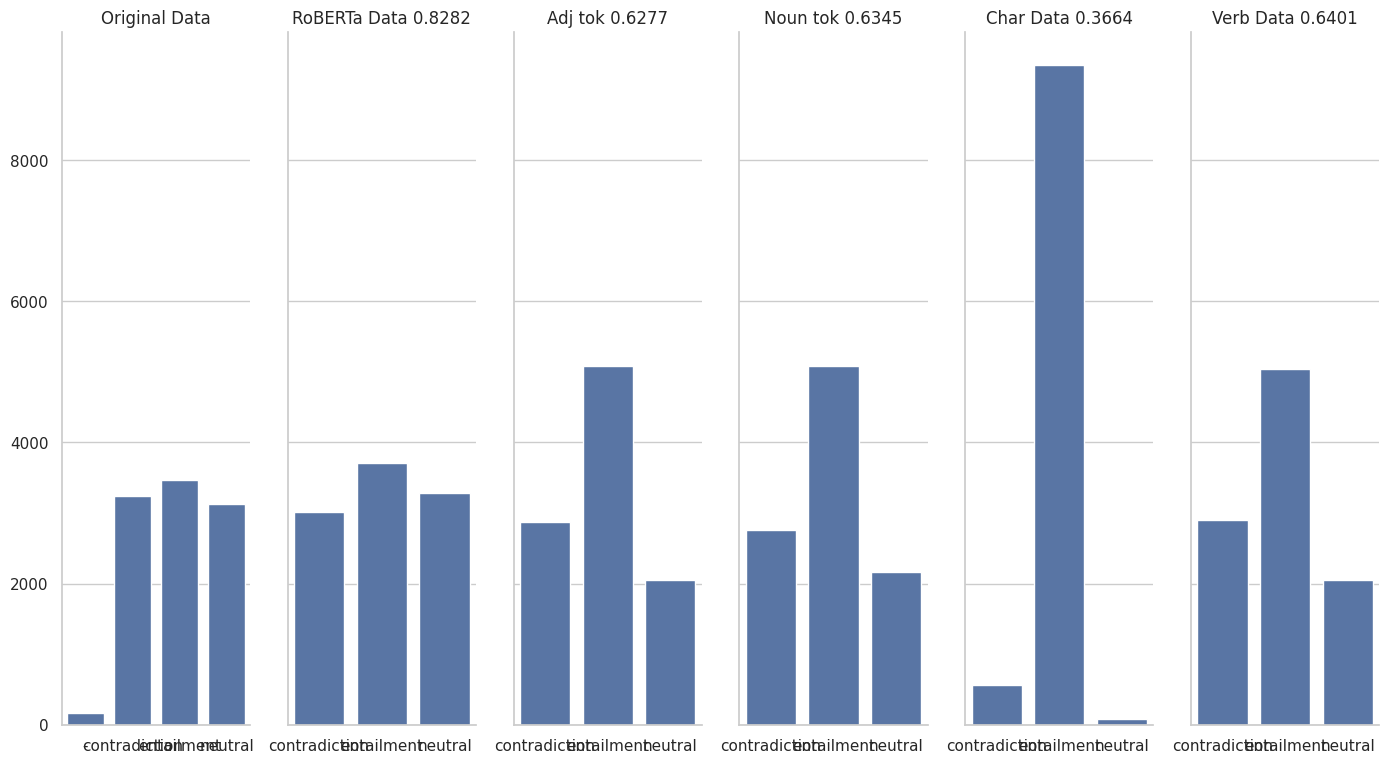

In [11]:
sns.set_theme(style="whitegrid")

def make_bar_plot(result_dict, title, ax):
    sns.barplot(result_dict, ax=ax)
    ax.set_title(title)

fig, axes = plt.subplots(1,6, figsize=(17,9), sharey=True)
make_bar_plot(gt_labels_num, "Original Data", axes[0])
make_bar_plot(results_standard_num, f"RoBERTa Data {sum(results_standard_labels == gt_labels)/len(gt_labels)}", axes[1])
make_bar_plot(results_adj_num, f"Adj tok {sum(results_adj_labels == gt_labels)/len(gt_labels)}", axes[2])
make_bar_plot(results_noun_num, f"Noun tok {sum(results_noun_labels == gt_labels)/len(gt_labels)}", axes[3])
make_bar_plot(results_char_num, f"Char Data {sum(results_char_labels == gt_labels)/len(gt_labels)}", axes[4])
make_bar_plot(results_verb_num, f"Verb Data {sum(results_verb_labels == gt_labels)/len(gt_labels)}", axes[5])
sns.despine()
plt.show()


In [15]:
import json
import pandas as pd

# data_path = "data/" + "/snli_1.0" + "/snli_1.0_test.jsonl"
data_path = "data/snli_1.0/snli_1.0_test.jsonl"

data = []
limit = 500_000
with open(data_path, "r") as file:
    for _ in range(limit):
        json_obj = file.readline()
        if json_obj != "":
            data += [json.loads(json_obj)]
        else:
            break


data_df = {
    "label": [],
    "sent1": [],
    "sent2": []
}

for datum in data:
    data_df["label"] += [datum["gold_label"]]
    data_df["sent1"] += [datum["sentence1"]] # premise
    data_df["sent2"] += [datum["sentence2"]] # hypothesis

data_df = pd.DataFrame(data_df)
print(data_df.shape)
print(data_df.head())

gt_labels_num = data_df["label"].value_counts().to_dict()
gt_labels_num = dict(sorted(gt_labels_num.items(), key=lambda x:x[0]))

gt_labels_num

(10000, 3)
           label                                              sent1  \
0        neutral  This church choir sings to the masses as they ...   
1     entailment  This church choir sings to the masses as they ...   
2  contradiction  This church choir sings to the masses as they ...   
3        neutral  A woman with a green headscarf, blue shirt and...   
4     entailment  A woman with a green headscarf, blue shirt and...   

                                   sent2  
0  The church has cracks in the ceiling.  
1        The church is filled with song.  
2    A choir singing at a baseball game.  
3                    The woman is young.  
4               The woman is very happy.  


{'-': 176, 'contradiction': 3237, 'entailment': 3368, 'neutral': 3219}

In [16]:
results_custom_verb_snli = json.load(open("verb_results_snli.json", "r"))
results_custom_verb_snli = get_labels_number(results_custom_verb_snli)
results_custom_noun_snli = json.load(open("noun_results_snli.json", "r"))
results_custom_noun_snli = get_labels_number(results_custom_noun_snli)
results_custom_char_snli = json.load(open("results_custom_tokenizer_snli.json", "r"))
results_custom_char_snli = get_labels_number(results_custom_char_snli)
results_normal_snli = json.load(open("results_normal_tokenizer_snli.json", "r"))
results_normal_snli = get_labels_number(results_normal_snli)

FileNotFoundError: [Errno 2] No such file or directory: 'verb_results_snli.json'

In [ ]:
# change tokens based on frequency appearing in testing data
# have noun tokenizer that tokenises everything but nouns - maybe just remove tokens
# avoid splitting illegaly in the first place
# adverserial attacks?

NameError: name 'make_bar_plot' is not defined

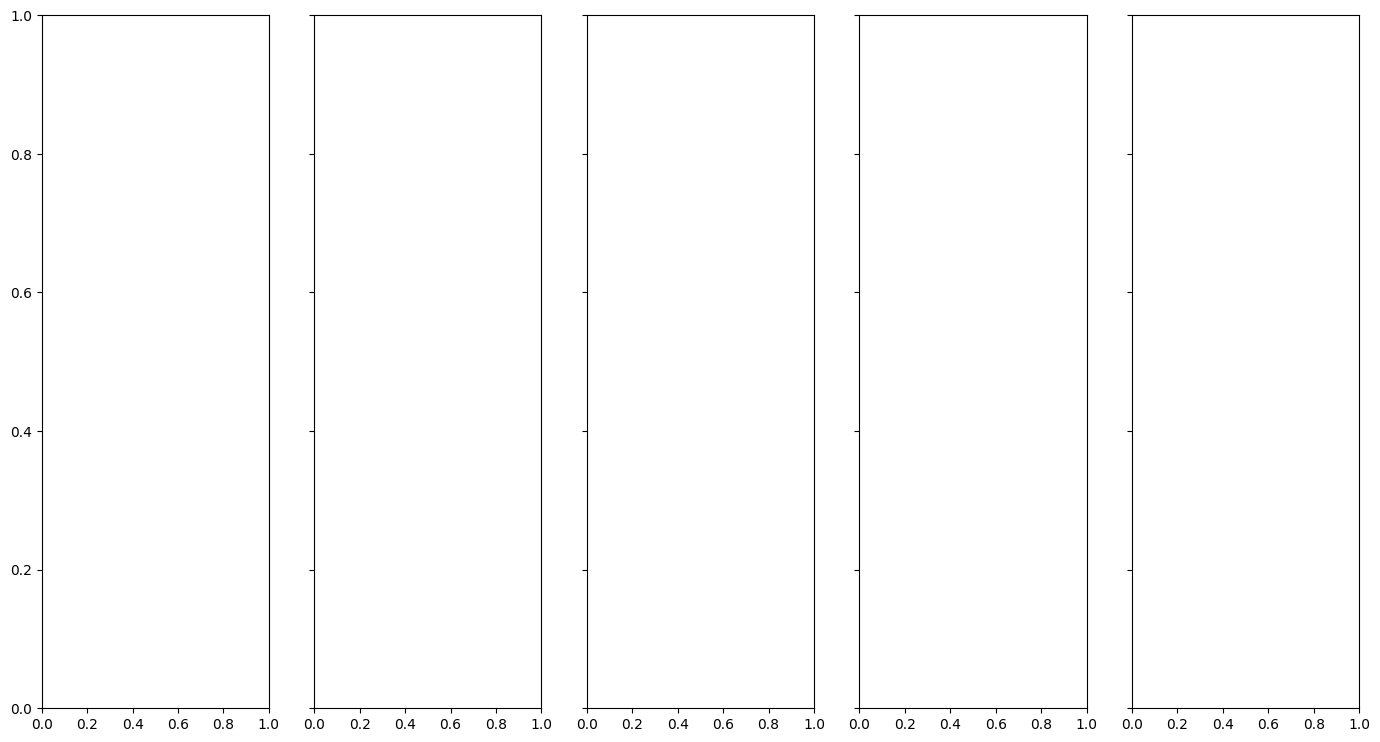

In [10]:
fig, axes = plt.subplots(1,5, figsize=(17,9), sharey=True)
make_bar_plot(gt_labels_num, "Original Data", axes[0])
make_bar_plot(results_normal_snli, "RoBERTa Tokenizer", axes[1])
make_bar_plot(results_custom_char_snli, "Split on Char Tokenizer", axes[2])
make_bar_plot(results_custom_verb_snli, "Split on Verb Tokenizer", axes[3])
make_bar_plot(results_custom_noun_snli, "Split on Noun Tokenizer", axes[4])
sns.despine()
plt.show()